In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import models, layers, optimizers, losses
import PIL
import os
import time
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!mkdir -p /content/apod/train /content/apod/validation

In [ ]:
!unzip /content/drive/MyDrive/APOD_Train.zip -d /content/apod/train

In [ ]:
!unzip /content/drive/MyDrive/APOD_Valid.zip -d /content/apod/validation 

In [5]:
import pathlib
train_dir = pathlib.Path('/content/apod/train/APOD_Train')

valid_dir = pathlib.Path('/content/apod/validation/APOD_Valid')

In [6]:
train_ds = tf.data.Dataset.list_files(str(train_dir/'*/*'))
valid_ds = tf.data.Dataset.list_files(str(valid_dir/'*/*'))
class_names = ['Fake', 'Real']

In [7]:
def process_image_label(filename):
    parts = tf.strings.split(filename, os.sep)
    label = tf.argmax(parts[-2] == class_names)
    image = tf.io.read_file(filename)
    image = tf.io.decode_image(image, channels=3, expand_animations=False,)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [256, 256])
    image = (image / 255.0)
    return image, label

In [8]:
# An augmentation function which will manipulate images randomly on each epoch
def augment(image, label, seed):
    # We are using the "stateless" random functions, so we need to generate
    # random seeds
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
    image = tf.image.stateless_random_flip_left_right(
        image, seed)
    image = tf.image.stateless_random_brightness(
        image, max_delta=0.5, seed=new_seed)
    image = tf.image.stateless_random_hue(
        image, 0.1, seed)
    image = tf.image.stateless_random_saturation(
        image, 0.5, 1.0, seed)

    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [9]:
rng = tf.random.Generator.from_seed(123, alg='philox')

# Create a wrapper function for updating seeds.
def f(x, y):
  seed = rng.make_seeds(2)[0]
  image, label = augment(x, y, seed)
  return image, label

In [10]:
# Training images are parsed with the processing and augmentation functions
train_data = (
    train_ds
    .map(process_image_label, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .map(f)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
    .batch(64)
)

# Validation images as well
valid_data = (
    valid_ds
    .map(process_image_label, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .map(f)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
    .batch(64)
)

In [11]:
model = models.Sequential([
    layers.Input(shape=(256, 256, 3), name='Input'),
    layers.Conv2D(32, 3, padding='same', activation='relu',
                    name='Conv_1'),
    layers.Conv2D(32, 3, padding='same', activation='relu',
                    name='Conv_2'),
    layers.MaxPooling2D(name='Pool_1'),
    layers.Conv2D(64, 3, padding='same', activation='relu',
                    name='Conv_3'),
    layers.Conv2D(64, 3, padding='same', activation='relu',
                    name='Conv_4'),
    layers.MaxPooling2D(name='Pool_2'),
    layers.Dropout(0.3, name='Dropout_1'),
    layers.Conv2D(128, 3, padding='same', activation='relu',
                    name='Conv_5'),
    layers.Conv2D(128, 3, padding='same', activation='relu',
                    name='Conv_6'),
    layers.MaxPooling2D(name='Pool_3'),
    layers.Dropout(0.5, name='Dropout_2'),
    layers.Flatten(name='Flatten'),
    layers.Dense(512, activation='relu', name='dense_1'),
    layers.Dense(256, activation='relu', name='dense_2'),
    layers.Dense(128, activation='relu', name='dense_3'),
    layers.Dense(2, activation='softmax', name='Output')
], name='CNN')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [12]:
epochs=20

history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs
)

Epoch 1/20
110/110 [==============================] - 85s 651ms/step - loss: 0.5869 - accuracy: 0.7104 - val_loss: 0.4995 - val_accuracy: 0.6922
Epoch 2/20
110/110 [==============================] - 55s 504ms/step - loss: 0.4574 - accuracy: 0.7521 - val_loss: 0.4812 - val_accuracy: 0.7742
Epoch 3/20
110/110 [==============================] - 56s 509ms/step - loss: 0.3916 - accuracy: 0.8067 - val_loss: 0.4663 - val_accuracy: 0.7907
Epoch 4/20
110/110 [==============================] - 56s 514ms/step - loss: 0.3681 - accuracy: 0.8263 - val_loss: 0.6190 - val_accuracy: 0.7412
Epoch 5/20
110/110 [==============================] - 56s 512ms/step - loss: 0.3574 - accuracy: 0.8379 - val_loss: 0.5746 - val_accuracy: 0.7339
Epoch 6/20
110/110 [==============================] - 56s 513ms/step - loss: 0.3275 - accuracy: 0.8524 - val_loss: 0.5469 - val_accuracy: 0.7783
Epoch 7/20
110/110 [==============================] - 57s 515ms/step - loss: 0.3032 - accuracy: 0.8669 - val_loss: 0.5583 - val_ac

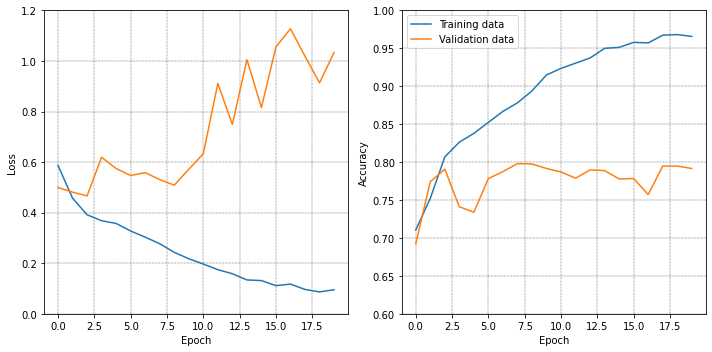

In [21]:
f, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_ylim(0.0, 1.2)
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].grid(color='black', linestyle='-.', linewidth=0.3)

ax[1].plot(history.history['accuracy'], label='Training data')
ax[1].plot(history.history['val_accuracy'], label='Validation data')
ax[1].set_ylim(0.6, 1)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].grid(color='black', linestyle='-.', linewidth=0.3)

plt.legend()
plt.tight_layout()
plt.show()

In [22]:
model.save('/content/drive/MyDrive/Group_15_Model_Trained')

In [23]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Group_15_Model_Trained')
loaded_model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 Conv_2 (Conv2D)             (None, 256, 256, 32)      9248      
                                                                 
 Pool_1 (MaxPooling2D)       (None, 128, 128, 32)      0         
                                                                 
 Conv_3 (Conv2D)             (None, 128, 128, 64)      18496     
                                                                 
 Conv_4 (Conv2D)             (None, 128, 128, 64)      36928     
                                                                 
 Pool_2 (MaxPooling2D)       (None, 64, 64, 64)        0         
                                                                 
 Dropout_1 (Dropout)         (None, 64, 64, 64)        0       

In [24]:
# zip the model
!zip -r /content/drive/MyDrive/Group_15_Model_Trained.zip /content/drive/MyDrive/Group_15_Model_Trained

  adding: content/drive/MyDrive/Group_15_Model_Trained/ (stored 0%)
  adding: content/drive/MyDrive/Group_15_Model_Trained/variables/ (stored 0%)
  adding: content/drive/MyDrive/Group_15_Model_Trained/variables/variables.data-00000-of-00001 (deflated 21%)
  adding: content/drive/MyDrive/Group_15_Model_Trained/variables/variables.index (deflated 71%)
  adding: content/drive/MyDrive/Group_15_Model_Trained/assets/ (stored 0%)
  adding: content/drive/MyDrive/Group_15_Model_Trained/saved_model.pb (deflated 89%)
  adding: content/drive/MyDrive/Group_15_Model_Trained/keras_metadata.pb (deflated 94%)


In [17]:
test_dir = pathlib.Path('/content/drive/MyDrive/APOD_Test')

In [18]:
test_data = test_dir.rglob('*')

In [19]:
for image in test_data:
  img = keras.preprocessing.image.load_img(image)
  img = img.resize((256, 256))
  img_tensor = keras.preprocessing.image.img_to_array(img)
  img_tensor = tf.expand_dims(img_tensor, 0)

  pred = model.predict(img_tensor)
  pred_index = pred.argmax()
  pred_class = class_names[pred_index]
  
  print(f'{image} is a {pred_class} image')

1/1 [==============================] - 1s 926ms/step
/content/drive/MyDrive/APOD_Test/ap000420.jpg is a Real image
1/1 [==============================] - 0s 80ms/step
/content/drive/MyDrive/APOD_Test/ap000421.jpg is a Real image
1/1 [==============================] - 0s 45ms/step
/content/drive/MyDrive/APOD_Test/ap000424.jpg is a Real image
1/1 [==============================] - 0s 85ms/step
/content/drive/MyDrive/APOD_Test/ap000423.jpg is a Real image
1/1 [==============================] - 0s 70ms/step
/content/drive/MyDrive/APOD_Test/ap000422.jpg is a Real image
1/1 [==============================] - 0s 80ms/step
/content/drive/MyDrive/APOD_Test/ap000313.jpg is a Real image
1/1 [==============================] - 0s 21ms/step
/content/drive/MyDrive/APOD_Test/ap000324.jpg is a Real image
1/1 [==============================] - 0s 20ms/step
/content/drive/MyDrive/APOD_Test/ap000405.jpg is a Real image
1/1 [==============================] - 0s 39ms/step
/content/drive/MyDrive/APOD_Test/ap

Using transfer learning to to try out a different model.

In [ ]:
from keras.applications.vgg16 import preprocess_input, VGG16
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model

vgg = VGG16(include_top=False, weights="imagenet", input_shape=(img_height, img_width, 3))

for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
x = Dropout(0.5)(x)  # Add Dropout layer with a dropout rate of 0.5
x = Dense(3, activation='softmax')(x)

vgg_style_model = Model(inputs=vgg.input, outputs=x)

In [ ]:
vgg_style_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Create an instance of EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = vgg_style_model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[early_stopping],
    epochs=10,

--------------------------------------------------------------------------